# Gerchberg-Saxton (GS) Algorithm for Holocurtain

### [Link to the paper](https://imaging.cs.cmu.edu/holocurtains/#home)

![GS algorithm in holocurtain paper](imgs/GS_paper.jpg)

## GS Algorithm Implementation

In [1]:
import numpy as np
import numpy.fft as F
import matplotlib.pyplot as plt
import PIL.Image as Image
import requests

In [2]:
# step1: Random Init for 2D binary image
def random_init(w: int, h: int) -> np.ndarray:
    return np.random.randint(0, 2, (w, h))

# plt.imshow(random_init(10, 10), cmap='gray')

In [28]:
def normalize_img(img: np.ndarray) -> np.ndarray:
    return (img - img.min()) / (img.max() - img.min())

In [4]:
def GS(target: np.ndarray, iter: int = 10, abr: np.ndarray = None) -> np.ndarray:
    h, w = target.shape
    # step1: Random Init for 2D binary image
    u = np.random.rand(h, w) >= 0.5
    u = u.astype(np.complex_)
    if abr is None:
        abr = np.ones_like(target)
    for _ in range(iter):
        # step2: Forward Propagation
        u = F.fft2(u * abr)
        u = F.fftshift(u)
        # step3: Amplitude Constraint
        u = np.sqrt(target) * np.exp(1j * np.angle(u))
        # step4: Backward Propagation
        u = F.ifftshift(u)
        u = F.ifft2(u)
        # step5: Binary Constraint
        u = np.real(u) >= 0
        u = u.astype(np.complex_)

    return u

## Define Evaluation Metrics
* **PSNR**: Peak Signal-to-Noise Ratio
* **SSIM**: Structural Similarity Index
* **NRMSE**: Normalized Root Mean Squared Error

In [34]:
def PSNR(target: np.ndarray, cmp: np.ndarray) -> float:
    mse = np.mean((target - cmp) ** 2)
    return 10 * np.log10(255 ** 2 / mse)

def SSIM(target: np.ndarray, cmp: np.ndarray) -> float:
    mu_x = np.mean(target)
    mu_y = np.mean(cmp)
    var_x = np.var(target)
    var_y = np.var(cmp)
    cov_xy = np.mean(target * cmp) - mu_x * mu_y
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2
    return (2 * mu_x * mu_y + c1) * (2 * cov_xy + c2) / ((mu_x ** 2 + mu_y ** 2 + c1) * (var_x + var_y + c2))

def NRMSE(target: np.ndarray, cmp: np.ndarray) -> float:
    return np.sqrt(np.mean((target - cmp) ** 2)) / (target.max() - target.min())

In [37]:
def show_metrics(target: np.ndarray, cmp: np.ndarray) -> None:
    target = normalize_img(target)
    cmp = normalize_img(cmp)
    print(f'PSNR: {PSNR(target, cmp):.2f}dB')
    print(f'SSIM: {SSIM(target, cmp):.2f}')
    print(f'NRMSE: {NRMSE(target, cmp):.2f}')

## Testing on 2D Images

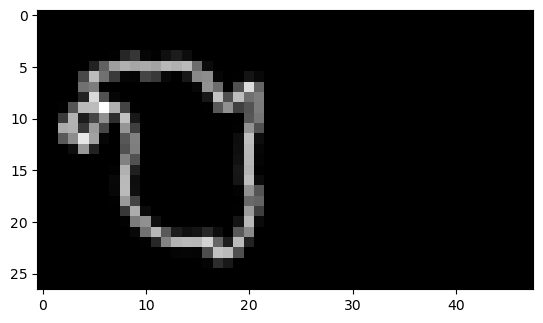

In [27]:
try:
    img = np.array(Image.open('imgs/target_pixelized.bmp'))
except FileNotFoundError:
    img = np.array(Image.open(requests.get('https://raw.githubusercontent.com/zhuyuezx/CSC494_holoprojector/main/Code/imgs/target_pixelized.bmp', stream=True).raw))
img = img / 255.
plt.imshow(img, cmap='gray')

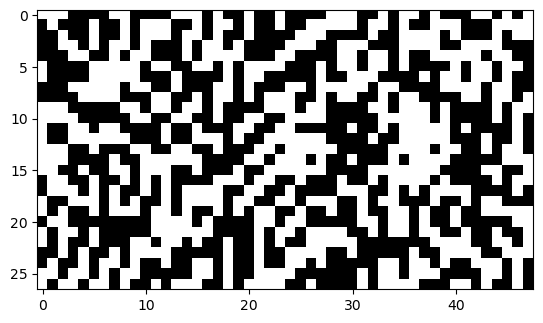

In [7]:
# Basic setting where there's no abrration
ret = GS(img, 1000)
# see the final result for step 5
plt.imshow(ret.real, cmap='gray')

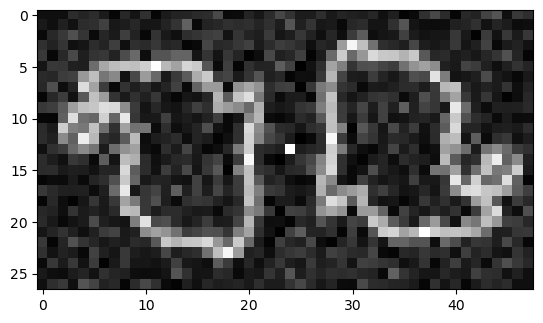

In [8]:
# See the final result for step 3
to_plot = np.fft.fft2(ret)
to_plot[0, 0] = 0
to_plot = normalize_img(np.abs(to_plot))
to_plot[0, 0] = to_plot.max()
to_plot = np.fft.fftshift(to_plot)
plt.imshow(np.abs(to_plot), cmap='gray')

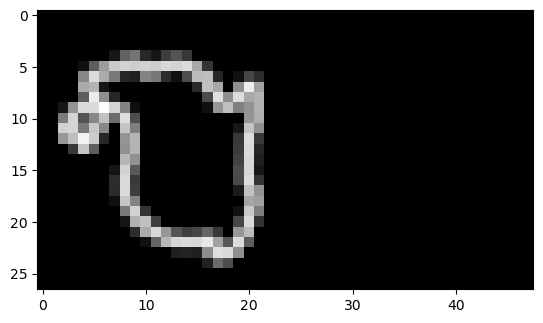

In [23]:
# See the final result for step 4
to_plot2 = np.fft.fft2(ret)
to_plot2 = np.sqrt(img) * np.exp(1j * np.angle(to_plot2))
plt.imshow(np.abs(to_plot2), cmap='gray')

In [38]:
show_metrics(img, np.abs(ret) ** 2)

PSNR: 51.36dB
SSIM: 0.97
NRMSE: 0.69
